# Spotify Recommendation Engine

For this capstone project, I will be attempting to use classification models to try to predict and recommend songs that I would enjoy, based on my own Spotify data. All of the data used in this capstone was collected by me using the Spotify API, Spotipy.

In [1]:
import pandas as pd
import yaml
from spotipy.oauth2 import SpotifyOAuth
import numpy as np
import json
import re 
import sys
import itertools
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from sklearn import datasets, linear_model
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression



from sklearn.feature_selection import RFECV
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report


import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from spotipy.oauth2 import SpotifyOAuth
import spotipy.util as util

import warnings
warnings.filterwarnings("ignore")

pd.set_option("max_rows", None)
pd.set_option('display.max_columns', None)

In [2]:
#loading datasets

#Datasets used to rate the training dataset
top_artist_df = pd.read_pickle("top_artists.pkl")
top_tracks_df = pd.read_pickle("top_tracks.pkl")

#Training Dataset
saved_tracks_df = pd.read_pickle("saved_tracks.pkl")

#Validation dataset
recommendation_tracks_df = pd.read_pickle("recommendation_tracks.pkl")

In [3]:
#removing duplicates of songs from the validation playlist
recommendation_tracks_df = recommendation_tracks_df.drop_duplicates(subset='id', keep="first").reset_index()

First thing I want to do is to check the shapes and variables in my playlists.

In [4]:
top_artist_df.shape

(60, 6)

In [5]:
top_artist_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         60 non-null     object
 1   uri        60 non-null     object
 2   type       60 non-null     object
 3   name       60 non-null     object
 4   genres     60 non-null     object
 5   followers  60 non-null     int64 
dtypes: int64(1), object(5)
memory usage: 2.9+ KB


In [6]:
#Changing "id" to "artist_id" to match other dataset
top_artist_df = top_artist_df.rename(columns={'id': 'artist_id'})
top_artist_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   artist_id  60 non-null     object
 1   uri        60 non-null     object
 2   type       60 non-null     object
 3   name       60 non-null     object
 4   genres     60 non-null     object
 5   followers  60 non-null     int64 
dtypes: int64(1), object(5)
memory usage: 2.9+ KB


In [7]:
#Looking at my top artists, which will be important for applying a ranking to the main dataset used for training
top_artist_df.head(20)

,artist_id,uri,type,name,genres,followers
0,3HiuzBlSW7pGDXlSFMhO2g,spotify:artist:3HiuzBlSW7pGDXlSFMhO2g,artist,Young Dolph,"[gangster rap, hip hop, memphis hip hop, rap, ...",1831256
1,2Waw2sSbqvAwK8NwACNjVo,spotify:artist:2Waw2sSbqvAwK8NwACNjVo,artist,Bo Burnham,[comic],1297100
2,2GeutBKR3pXPk1OBmDYWD3,spotify:artist:2GeutBKR3pXPk1OBmDYWD3,artist,Laurent Korcia,[violin],1497
3,1yxSLGMDHlW21z4YXirZDS,spotify:artist:1yxSLGMDHlW21z4YXirZDS,artist,Black Eyed Peas,"[dance pop, pop, pop rap]",6276967
4,3WrFJ7ztbogyGnTHbHJFl2,spotify:artist:3WrFJ7ztbogyGnTHbHJFl2,artist,The Beatles,"[beatlesque, british invasion, classic rock, m...",21322261
5,2DaxqgrOhkeH0fpeiQq2f4,spotify:artist:2DaxqgrOhkeH0fpeiQq2f4,artist,Oasis,"[beatlesque, britpop, madchester, permanent wa...",6847875
6,3TVXtAsR1Inumwj472S9r4,spotify:artist:3TVXtAsR1Inumwj472S9r4,artist,Drake,"[canadian hip hop, canadian pop, hip hop, rap,...",59353055
7,0RESbWvOMyua0yuyVrztJ5,spotify:artist:0RESbWvOMyua0yuyVrztJ5,artist,Key Glock,"[hip hop, memphis hip hop, rap, southern hip h...",1023419
8,13y7CgLHjMVRMDqxdx0Xdo,spotify:artist:13y7CgLHjMVRMDqxdx0Xdo,artist,Gucci Mane,"[atl hip hop, dirty south rap, gangster rap, h...",4082289
9,5K4W6rqBFWDnAN6FQUkS6x,spotify:artist:5K4W6rqBFWDnAN6FQUkS6x,artist,Kanye West,"[chicago rap, rap]",15846203


In [8]:
top_tracks_df.shape

(60, 35)

In [9]:
top_tracks_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 35 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  60 non-null     object 
 1   name                60 non-null     object 
 2   popularity          60 non-null     int64  
 3   type                60 non-null     object 
 4   is_local            60 non-null     bool   
 5   explicit            60 non-null     bool   
 6   duration_ms         60 non-null     int64  
 7   disc_number         60 non-null     int64  
 8   track_number        60 non-null     int64  
 9   artist_id           60 non-null     object 
 10  artist_name         60 non-null     object 
 11  album_artist_id     60 non-null     object 
 12  album_artist_name   60 non-null     object 
 13  album_id            60 non-null     object 
 14  album_name          60 non-null     object 
 15  album_release_date  60 non-null     object 
 16  album_trac

In [10]:
top_tracks_df.isnull().sum()

id                    0
name                  0
popularity            0
type                  0
is_local              0
explicit              0
duration_ms           0
disc_number           0
track_number          0
artist_id             0
artist_name           0
album_artist_id       0
album_artist_name     0
album_id              0
album_name            0
album_release_date    0
album_tracks          0
album_type            0
genres                0
album_genres          0
danceability          0
energy                0
key                   0
loudness              0
mode                  0
speechiness           0
acousticness          0
instrumentalness      0
liveness              0
valence               0
tempo                 0
uri                   0
track_href            0
analysis_url          0
time_signature        0
dtype: int64

In [11]:
saved_tracks_df.shape

(1133, 36)

In [12]:
saved_tracks_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1133 entries, 0 to 1132
Data columns (total 36 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  1131 non-null   object 
 1   name                1133 non-null   object 
 2   popularity          1133 non-null   int64  
 3   type                1131 non-null   object 
 4   is_local            1133 non-null   bool   
 5   explicit            1133 non-null   bool   
 6   duration_ms         1131 non-null   float64
 7   disc_number         1133 non-null   int64  
 8   track_number        1133 non-null   int64  
 9   artist_id           1133 non-null   object 
 10  artist_name         1133 non-null   object 
 11  album_artist_id     1133 non-null   object 
 12  album_artist_name   1133 non-null   object 
 13  album_id            1133 non-null   object 
 14  album_name          1133 non-null   object 
 15  album_release_date  1133 non-null   object 
 16  album_

In [13]:
saved_tracks_df.isnull().sum()

id                    2
name                  0
popularity            0
type                  2
is_local              0
explicit              0
duration_ms           2
disc_number           0
track_number          0
artist_id             0
artist_name           0
album_artist_id       0
album_artist_name     0
album_id              0
album_name            0
album_release_date    0
album_tracks          0
album_type            0
added_at              0
genres                0
album_genres          0
danceability          2
energy                2
key                   2
loudness              2
mode                  2
speechiness           2
acousticness          2
instrumentalness      2
liveness              2
valence               2
tempo                 2
uri                   2
track_href            2
analysis_url          2
time_signature        2
dtype: int64

This dataset seems to be missing data for 2 rows of data in a dataset of 1100+. I think I can safely drop these rows without effecting data.

In [14]:
#dropping na values
saved_tracks_df = saved_tracks_df.dropna()
saved_tracks_df.isnull().sum()

#looking good now no missing data

id                    0
name                  0
popularity            0
type                  0
is_local              0
explicit              0
duration_ms           0
disc_number           0
track_number          0
artist_id             0
artist_name           0
album_artist_id       0
album_artist_name     0
album_id              0
album_name            0
album_release_date    0
album_tracks          0
album_type            0
added_at              0
genres                0
album_genres          0
danceability          0
energy                0
key                   0
loudness              0
mode                  0
speechiness           0
acousticness          0
instrumentalness      0
liveness              0
valence               0
tempo                 0
uri                   0
track_href            0
analysis_url          0
time_signature        0
dtype: int64

In [15]:
#saved_tracks_df.info()

In [16]:
#renaming main playlist to df for simplicity
df = saved_tracks_df

First thing I want to do is apply a rating to my saved songs dataset. To apply a rating, I will give the songs that are in my "top artists" a rating of 1, and everything else a 0. "Rating" will be the variable I will attempt to predict based on the content of my songs. 

I originally wanted to use specific song data to train and test models, but the "top tracks" playlist was only 60 songs long, so I was only able to rate a maximum of 60 songs. Whereas when using top artist data, I was able to apply a rating to 399 songs. I also noticed a large portion of my top songs were by my top artists, so there was a large overlap. I am confident I can get good results by analyzing this song data from my top artists.

In [17]:
#Only 20 top songs get rated when using top songs, 
#think it best to use a rating system with my top artists as that gives me 399 ratings


#saved_tracks_df['ratings'] = saved_tracks_df['id'].apply(lambda x: 1 if x in top_tracks_df.values else 0)
#saved_tracks_df['ratings'].head(25)

In [18]:
#Lambda function to add a rating for all songs that are by one of my top artists

df['ratings'] = df['artist_id'].apply(lambda x: 1 if x in top_artist_df.values else 0)
df['ratings']

0       0
1       1
2       0
3       0
4       0
5       0
6       0
7       0
8       1
9       1
10      1
11      1
12      1
13      1
14      1
15      1
16      0
17      0
18      1
19      1
20      1
21      1
22      1
23      1
24      0
25      0
26      1
27      0
28      0
29      1
30      0
31      1
32      0
33      0
34      0
35      0
36      0
37      0
38      0
39      0
40      0
41      0
42      0
43      0
44      1
45      1
46      1
47      1
48      1
49      0
50      0
51      1
52      1
53      0
54      1
55      1
56      0
57      1
58      1
59      0
60      0
61      1
62      0
63      1
64      1
65      0
66      1
67      1
68      0
69      0
70      0
71      0
72      0
73      0
74      0
75      0
76      0
77      1
78      0
79      0
80      0
81      0
82      0
83      0
84      0
85      0
86      0
87      0
88      0
89      0
90      0
91      1
92      0
93      1
94      0
95      0
96      1
97      0
98      1
99      0


In [19]:
#viewing df to see ratings
df.head(25)

,id,name,popularity,type,is_local,explicit,duration_ms,disc_number,track_number,artist_id,artist_name,album_artist_id,album_artist_name,album_id,album_name,album_release_date,album_tracks,album_type,added_at,genres,album_genres,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,uri,track_href,analysis_url,time_signature,ratings
0,6xgwv5ao2qYqmpkuG1etFc,Minor Waltz,6,audio_features,False,False,228893.0,1,2,3zz4BITBs6xvnzw2vtQi2D,Michel Portal,2GeutBKR3pXPk1OBmDYWD3,Laurent Korcia,1mDZvK2Vg7hedk6KEKQNmC,Doubles Jeux,2006-11-07,17,album,2021-12-14T20:31:16Z,"[bandoneon, classical clarinet, french jazz]",[violin],0.3950,0.1510,1.0,-18.294,0.0,0.0519,0.73400,0.053400,0.1550,0.1580,119.908,spotify:track:6xgwv5ao2qYqmpkuG1etFc,https://api.spotify.com/v1/tracks/6xgwv5ao2qYq...,https://api.spotify.com/v1/audio-analysis/6xgw...,3.0,0
1,3CFR1oY47Ph2fULELeH6Rd,Schindler's List Theme,1,audio_features,False,False,225373.0,1,12,3dRfiJ2650SZu6GbydcHNb,John Williams,2GeutBKR3pXPk1OBmDYWD3,Laurent Korcia,5GWDKESsOoOy3rh9W4tKrZ,Laurent Korcia: Cinema,2009-01-01,20,album,2021-12-14T20:08:51Z,[soundtrack],[violin],0.0995,0.2300,2.0,-13.785,0.0,0.0517,0.89500,0.273000,0.0643,0.0637,47.542,spotify:track:3CFR1oY47Ph2fULELeH6Rd,https://api.spotify.com/v1/tracks/3CFR1oY47Ph2...,https://api.spotify.com/v1/audio-analysis/3CFR...,4.0,1
2,2HCs8VTLo6Vkzu06gVt1C1,瘋狂世界,8,audio_features,False,False,170160.0,1,9,1bONVLlQIiuULYblokrPxj,周璇,1bONVLlQIiuULYblokrPxj,周璇,38va8KTRv5zLmAiIaORbSa,"群星會, Vol.1 (珍藏系列 上)",1940-02-01,21,album,2021-12-14T19:38:12Z,"[c-pop, vintage chinese pop]","[c-pop, vintage chinese pop]",0.3010,0.1580,6.0,-17.066,0.0,0.0370,0.99300,0.634000,0.1310,0.7760,179.136,spotify:track:2HCs8VTLo6Vkzu06gVt1C1,https://api.spotify.com/v1/tracks/2HCs8VTLo6Vk...,https://api.spotify.com/v1/audio-analysis/2HCs...,4.0,0
3,5B0qLRZewG1huy6o2JgQAo,交換,2,audio_features,False,False,195507.0,1,8,1bONVLlQIiuULYblokrPxj,周璇,1bONVLlQIiuULYblokrPxj,周璇,38va8KTRv5zLmAiIaORbSa,"群星會, Vol.1 (珍藏系列 上)",1940-02-01,21,album,2021-12-14T19:28:06Z,"[c-pop, vintage chinese pop]","[c-pop, vintage chinese pop]",0.3850,0.1000,4.0,-18.724,0.0,0.0423,0.99100,0.393000,0.0968,0.2960,118.056,spotify:track:5B0qLRZewG1huy6o2JgQAo,https://api.spotify.com/v1/tracks/5B0qLRZewG1h...,https://api.spotify.com/v1/audio-analysis/5B0q...,4.0,0
4,0vDU9V9SLZgqkQJ68HhnEU,Element,32,audio_features,False,True,131056.0,1,1,0cHInYwq4GHrC3UotzgVQw,870glizzy,0cHInYwq4GHrC3UotzgVQw,870glizzy,5PiTbD9zwmruivcjfPOYhr,Element,2021-09-03,1,album,2021-12-11T16:12:06Z,[],[],0.6660,0.6960,7.0,-7.867,1.0,0.4070,0.07590,0.000000,0.1080,0.5710,139.746,spotify:track:0vDU9V9SLZgqkQJ68HhnEU,https://api.spotify.com/v1/tracks/0vDU9V9SLZgq...,https://api.spotify.com/v1/audio-analysis/0vDU...,4.0,0
5,6Gifhuvyk4uPDGSRrtw8Y6,"Schwanengesang, D. 957: Ständchen ""Leise flehe...",52,audio_features,False,False,260000.0,1,12,2p0UyoPfYfI76PCStuXfOP,Franz Schubert,2p0UyoPfYfI76PCStuXfOP,Franz Schubert,0z8Lnbz84Irq0iBQcTS4es,Schubert: Songs without Words,1996-01-01,17,album,2021-12-06T19:49:54Z,"[classical, classical era, early romantic era]","[classical, classical era, early romantic era]",0.1150,0.0357,2.0,-24.281,0.0,0.0453,0.98000,0.905000,0.0900,0.0555,178.716,spotify:track:6Gifhuvyk4uPDGSRrtw8Y6,https://api.spotify.com/v1/tracks/6Gifhuvyk4uP...,https://api.spotify.com/v1/audio-analysis/6Gif...,3.0,0
6,0vf2eBw2inhl8y61cYQMv2,Devil Town,82,audio_features,False,False,179955.0,1,8,2hR4h1Cao2ueuI7Cx9c7V8,Cavetown,2hR4h1Cao2ueuI7Cx9c7V8,Cavetown,0ZyaO9oGhq7blYJzo3l65t,Cavetown,2015-11-09,8,album,2021-12-03T13:31:53Z,"[bedroom pop, indie pop]","[bedroom pop, indie pop]",0.5760,0.7590,3.0,-8.165,1.0,0.0599,0.12000,0.000000,0.1210,0.5010,99.969,spotify:track:0vf2eBw2inhl8y61cYQMv2,https://api.spotify.com/v1/tracks/0vf2eBw2inhl...,https://api.spotify.com/v1/audio-analysis/0vf2...,4.0,0
7,6K0LB4XItoRSkKZSkVTS4d,Substance Abuse,13,audio_features,False,True,212245.0,1,8,3kf0gOpxWtkyeMNJVDQPtd,Sm

In [20]:
df.ratings.sum()

399

Now That I have ratings to my song data, I will move right into training my data.

For training the data, I am looking only at the variables that describe the musical contents of the song. I am not interested in popularity, song length, whether song is explicit, or the song type.

### Training Data

In [21]:
# Training data
X = df[['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 
        'liveness', 'valence', 'tempo', 'time_signature', 'genres']]
y = df['ratings']


# Create genre columns to turn the genres column into a numerical column
X = X.drop('genres', 1).join(X['genres'].str.join('|').str.get_dummies())

#Loading in copy of recommendation tracks from spotify's own algorythms, will use this later for validation
X_recommend = recommendation_tracks_df.copy()

# Create genre columns to turn the genres column into a numerical column
X_recommend = X_recommend.drop('genres', 1).join(X_recommend['genres'].str.join('|').str.get_dummies())


#Ensuring features are consistent
X = X[X.columns.intersection(X_recommend.columns)]
X_recommend = X_recommend[X_recommend.columns.intersection(X.columns)]


# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state= 7)

In [22]:
#checking to make sure shape matches up
X_train.shape

(904, 263)

In [23]:
y_train.shape

(904,)

In [24]:
X_recommend.shape

(4338, 263)

### Feature Importance

Fitting estimator with 263 features.
Fitting estimator with 262 features.
Fitting estimator with 261 features.
Fitting estimator with 260 features.
Fitting estimator with 259 features.
Fitting estimator with 258 features.
Fitting estimator with 257 features.
Fitting estimator with 256 features.
Fitting estimator with 255 features.
Fitting estimator with 254 features.
Fitting estimator with 253 features.
Fitting estimator with 252 features.
Fitting estimator with 251 features.
Fitting estimator with 250 features.
Fitting estimator with 249 features.
Fitting estimator with 248 features.
Fitting estimator with 247 features.
Fitting estimator with 246 features.
Fitting estimator with 245 features.
Fitting estimator with 244 features.
Fitting estimator with 243 features.
Fitting estimator with 242 features.
Fitting estimator with 241 features.
Fitting estimator with 240 features.
Fitting estimator with 239 features.
Fitting estimator with 238 features.
Fitting estimator with 237 features.
F

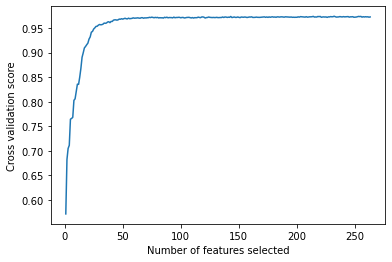

In [25]:
#Cross Validation for features

rf = RandomForestClassifier(n_estimators = 1000, random_state = 7 )
rfecv = RFECV(estimator=rf, step=1, n_jobs=-1, cv=StratifiedKFold(2), verbose=1, scoring='roc_auc')
rfecv.fit(X_train, y_train)

print(f'Optimal number of features: {rfecv.n_features_}')

plt.figure()
plt.xlabel('Number of features selected')
plt.ylabel('Cross validation score')
plt.plot(range(1, len(rfecv.grid_scores_)+1), rfecv.grid_scores_)
plt.show()

#Optimal number of features is 232

#commented out to save run time when restarting kernel

In [26]:
#Random Forest classifier
rf = RandomForestClassifier(n_estimators = 1000, random_state = 7 )

#fitting model now to see a list of important features for my song data
rf.fit(X_train, y_train)

important_features = {}
for x,y in enumerate(rf.feature_importances_):
    important_features[x] = y

important_features_list = sorted(important_features,
                                 key=important_features.get,
                                 reverse=True)

# Printing the top features
for i in range(len(important_features_list[:50])):
    print(f"{i+1}. {X_train.columns[important_features_list[i]]} {important_features[important_features_list[i]]}")

1. rap 0.07338067434111464
2. speechiness 0.050407626497393415
3. energy 0.04533777337736288
4. danceability 0.043416393481863165
5. instrumentalness 0.042697105051097604
6. loudness 0.04092880252721668
7. acousticness 0.03507823743659393
8. detroit hip hop 0.034302485156577356
9. tempo 0.03183338031885002
10. valence 0.03137924787590353
11. liveness 0.030653429870509764
12. hip hop 0.027732750028463874
13. chicago rap 0.024633724420120705
14. new orleans rap 0.021977039079103367
15. atl hip hop 0.02195072244400758
16. underground hip hop 0.021663480368939565
17. escape room 0.019497149952502593
18. west coast rap 0.01829968900060041
19. key 0.018220628076729473
20. kansas city hip hop 0.01813147225963202
21. psychedelic hip hop 0.017594989537704227
22. east coast hip hop 0.017516561768414304
23. pop rap 0.01721553619200151
24. canadian hip hop 0.01696395916559439
25. conscious hip hop 0.016271585267872674
26. southern hip hop 0.0150330855380227
27. melodic rap 0.013817814133315462
28.

This lists of feature importance at first glance looks accurate. My favorite type of music, as well as my favorite/ most listened to artists I would classify as rap or hip hop. Most of the music I listen to is at the gym, where I prefer loud, fast-tempo rap songs to fuel my workout.

One other thing I notice, is that the music type is not extremely diverse. Most of the genres of importance could theoretically all fall under the same large umbrella of "rap music". (several different types of hip hop and rap). My music taste is very diverse, as seen in my saved_playlist dataframe. I have different types of musical tastes including classical, rock, alternative, even some songs sung in Chinese from artists who I cannot pronounce the name of, from the 1940's. Based on my top artist data, I would predict that the models will recommend primarily rap and hip hop type music. While not as diverse as it could be, I believe the results I get may be even more accurate in that the songs it recommends will have a higher chance of me liking them.

The 3 types of classification models I want to test my on data on are Logistical Regression, kNN, and Random Forest. Between these 3 models, I will select the best model and test it on a dataset of songs from someone else randomly found on Kaggle, and try to predict which songs from that dataset I will like the most.

### Logistic Regression

In [27]:
#Logistic Regression
lr = LogisticRegression()

#fit model with train data
lr.fit(X_train, y_train)

print('The accuracy score is: ' + str(accuracy_score(lr.predict(X_test), y_test)))
print(classification_report(lr.predict(X_test), y_test))

The accuracy score is: 0.8986784140969163
              precision    recall  f1-score   support

           0       0.95      0.91      0.93       158
           1       0.80      0.88      0.84        69

    accuracy                           0.90       227
   macro avg       0.87      0.89      0.88       227
weighted avg       0.90      0.90      0.90       227



In [28]:
#Checking accuracy after SCALING Data
minmax_scaler = MinMaxScaler()
X_train_scaled = pd.DataFrame(minmax_scaler.fit_transform(X_train), columns=X_train.columns)

#Logistic Regression
lr = LogisticRegression()

#fit model with train data
lr.fit(X_train_scaled, y_train)

print('The accuracy score is: ' + str(accuracy_score(lr.predict(X_test), y_test)))
print(classification_report(lr.predict(X_test), y_test))

The accuracy score is: 0.6651982378854625
              precision    recall  f1-score   support

           0       1.00      0.67      0.80       227
           1       0.00      0.00      0.00         0

    accuracy                           0.67       227
   macro avg       0.50      0.33      0.40       227
weighted avg       1.00      0.67      0.80       227



It seems that scaling the data makes the accuracy and models perform much worse. I will test my data on more models to see how this compares before making any decisions.

### KNN

In [29]:
knn = KNeighborsClassifier()

#First thing I want to do is test for the optimal number of n_neighbors
knn_params = {'n_neighbors': range(1, 20)}

knn_gcv = GridSearchCV(knn, knn_params, n_jobs=1, cv=StratifiedKFold(2), scoring='roc_auc')
knn_gcv.fit(X_train, y_train)
knn_gcv.best_params_, knn_gcv.best_score_

({'n_neighbors': 2}, 0.585026889408075)

In [30]:
#KNN model with training data, using optimal n_neighbors of 2
knn = KNeighborsClassifier(n_neighbors = 2)

#Fitting Model with UNSCALED training data
knn.fit(X_train, y_train)

#Accuracy score and classification report
print('The accuracy score is: ' + str(accuracy_score(knn.predict(X_test), y_test)))
print(classification_report(knn.predict(X_test), y_test))

The accuracy score is: 0.6563876651982379
              precision    recall  f1-score   support

           0       0.85      0.70      0.77       185
           1       0.26      0.48      0.34        42

    accuracy                           0.66       227
   macro avg       0.56      0.59      0.55       227
weighted avg       0.74      0.66      0.69       227



In [31]:
#Checking Model after SCALING Data
#KNN model with training data, using optimal n_neighbors of 2
knn = KNeighborsClassifier(n_neighbors = 2)

#Fitting Model with training data
knn.fit(X_train_scaled, y_train)

#Accuracy score and classification report
print('The accuracy score is: ' + str(accuracy_score(knn.predict(X_test), y_test)))
print(classification_report(knn.predict(X_test), y_test))

The accuracy score is: 0.6651982378854625
              precision    recall  f1-score   support

           0       1.00      0.67      0.80       227
           1       0.00      0.00      0.00         0

    accuracy                           0.67       227
   macro avg       0.50      0.33      0.40       227
weighted avg       1.00      0.67      0.80       227



Using the optimal n_neighbors of 2 (as opposed to the default n_neighbors of 5) improved the accuracy score about 0.05 from roughly 0.60 to 0.65. Then a very minor inmprovement of 0.01 after using scaled data. This is ok, but does not compare to the Logistic Regression Model. Think it is sae to say this is the least effective

The final model I will test my data on will be a Random Forest Model.

### Random Forest

In [32]:
rfc = RandomForestClassifier()

#First thing I want to do is test for the optimal parameters
rfc_params = {'min_samples_leaf': [1, 3, 5, 10, 20], 
              'max_depth': [2, 4, 5, 10, 12, 16, 20], 
             }

rfc_gcv = GridSearchCV(rfc, rfc_params, n_jobs=1, cv=StratifiedKFold(3), scoring='roc_auc')
rfc_gcv.fit(X_train, y_train)
rfc_gcv.best_params_, rfc_gcv.best_score_

({'max_depth': 20, 'min_samples_leaf': 1}, 0.9755663179265204)

In [39]:
#Finally, will test data on a Random Forest Classifier
rfc = RandomForestClassifier(max_depth = 20, min_samples_leaf = 1)

#Fitting Model with training data
rfc.fit(X_train, y_train)

#Accuracy score and classification report
print('The accuracy score is: ' + str(accuracy_score(rfc.predict(X_test), y_test)))
print(classification_report(rfc.predict(X_test), y_test))

The accuracy score is: 0.947136563876652
              precision    recall  f1-score   support

           0       0.99      0.94      0.96       159
           1       0.87      0.97      0.92        68

    accuracy                           0.95       227
   macro avg       0.93      0.95      0.94       227
weighted avg       0.95      0.95      0.95       227



In [34]:
#Finally, will test SCALED data on a Random Forest Classifier
#rfc = RandomForestClassifier(max_depth = 16, min_samples_leaf = 1)

#Fitting Model with training data
#rfc.fit(X_train_scaled, y_train)

#Accuracy score and classification report
#print('The accuracy score is: ' + str(accuracy_score(rfc.predict(X_test), y_test)))
#print(classification_report(rfc.predict(X_test), y_test))


#Random Forest Does not need scaled data

This Random Forest Classifier Model seems to perform the best over any model, scaled or unscaled. This will be the model I use.

### Recommendations

For the recommendations, I will be importing a dataset I collected from my spotify of spotify's recommended tracks that they believe I would enjoy. This will be the validation set that I will use to see which of those songs my model thinks I will enjoy the most

In [40]:
#creating a rating column for recommendation playlist
recommendation_tracks_df['ratings'] = rfc_gcv.predict(X_recommend)

#Creating a probability rating for the songs
recommendation_tracks_df['prob_ratings'] = rfc_gcv.predict_proba(X_recommend)[:,1]

In [41]:
#Sort playlist by ratings
recommendation_tracks_df[recommendation_tracks_df['ratings'] == 1].sort_values('prob_ratings', ascending = False).head(50)

,index,id,name,popularity,type,is_local,explicit,duration_ms,disc_number,track_number,artist_id,artist_name,album_artist_id,album_artist_name,album_id,album_name,album_release_date,album_tracks,album_type,genres,album_genres,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,uri,track_href,analysis_url,time_signature,ratings,prob_ratings
3309,4001,0y9uTzK9cNKSAEHnpeRG8C,DUCKWORTH.,69,audio_features,False,True,248613,1,14,2YZyLoL8N0Wb9xBt1NhZWg,Kendrick Lamar,2YZyLoL8N0Wb9xBt1NhZWg,Kendrick Lamar,4eLPsYPBmXABThSJ821sqY,DAMN.,2017-04-14,14,album,"[conscious hip hop, hip hop, rap, west coast rap]","[conscious hip hop, hip hop, rap, west coast rap]",0.552,0.731,7,-6.873,1,0.6150,0.053600,0.000000,0.2580,0.6320,174.516,spotify:track:0y9uTzK9cNKSAEHnpeRG8C,https://api.spotify.com/v1/tracks/0y9uTzK9cNKS...,https://api.spotify.com/v1/audio-analysis/0y9u...,4,1,0.977815
2191,2460,28FGV3ORH14MYORd7s5dlU,Not Alike (feat. Royce Da 5'9),69,audio_features,False,True,288087,1,8,7dGJo4pcD2V6oG8kP0tJRR,Eminem,7dGJo4pcD2V6oG8kP0tJRR,Eminem,3HNnxK7NgLXbDoxRZxNWiR,Kamikaze,2018-08-31,13,album,"[detroit hip hop, hip hop, rap]","[detroit hip hop, hip hop, rap]",0.904,0.756,10,-3.746,1,0.3200,0.069200,0.000000,0.3390,0.3420,140.005,spotify:track:28FGV3ORH14MYORd7s5dlU,https://api.spotify.com/v1/tracks/28FGV3ORH14M...,https://api.spotify.com/v1/audio-analysis/28FG...,4,1,0.970154
2766,3191,439TlnnznSiBbQbgXiBqAd,m.A.A.d city,69,audio_features,False,True,350120,1,8,2YZyLoL8N0Wb9xBt1NhZWg,Kendrick Lamar,2YZyLoL8N0Wb9xBt1NhZWg,Kendrick Lamar,6PBZN8cbwkqm1ERj2BGXJ1,"good kid, m.A.A.d city",2012,13,album,"[conscious hip hop, hip hop, rap, west coast rap]","[conscious hip hop, hip hop, rap, west coast rap]",0.487,0.729,2,-6.815,1,0.2710,0.053800,0.000004,0.4400,0.2170,91.048,spotify:track:439TlnnznSiBbQbgXiBqAd,https://api.spotify.com/v1/tracks/439TlnnznSiB...,https://api.spotify.com/v1/audio-analysis/439T...,4,1,0.960203
3121,3725,3aGibUHhQyBsyumYHylw0K,Backseat Freestyle,70,audio_features,False,True,212653,1,3,2YZyLoL8N0Wb9xBt1NhZWg,Kendrick Lamar,2YZyLoL8N0Wb9xBt1NhZWg,Kendrick Lamar,3DGQ1iZ9XKUQxAUWjfC34w,"good kid, m.A.A.d city (Deluxe)",2012,17,album,"[conscious hip hop, hip hop, rap, west coast rap]","[conscious hip hop, hip hop, rap, west coast rap]",0.546,0.651,1,-7.601,1,0.3000,0.000739,0.000000,0.2350,0.6460,77.878,spotify:track:3aGibUHhQyBsyumYHylw0K,https://api.spotify.com/v1/tracks/3aGibUHhQyBs...,https://api.spotify.com/v1/audio-analysis/3aGi...,4,1,0.957577
2200,2473,40YbWniIEmqy6s58fYXLUh,Never Love Again,67,audio_features,False,True,177547,1,14,7dGJo4pcD2V6oG8kP0tJRR,Eminem,7dGJo4pcD2V6oG8kP0tJRR,Eminem,4otkd9As6YaxxEkIjXPiZ6,Music To Be Murdered By,2020-01-17,20,album,"[detroit hip hop, hip hop, rap]","[detroit hip hop, hip hop, rap]",0.747,0.899,5,-5.125,0,0.2460,0.100000,0.000000,0.4860,0.5810,92.029,spotify:track:40YbWniIEmqy6s58fYXLUh,https://api.spotify.com/v1/tracks/40YbWniIEmqy...,https://api.spotify.com/v1/audio-analysis/40Yb...,4,1,0.951953
2966,3474,6HZILIRieu8S0iqY8kIKhj,DNA.,80,audio_features,False,True,185947,1,2,2YZyLoL8N0Wb9xBt1NhZWg,Kendrick Lamar,2YZyLoL8N0Wb9xBt1NhZWg,Kendrick Lamar,4eLPsYPBmXABThSJ821sqY,DAMN.,2017-04-14,14,album,"[conscious hip hop, hip hop, rap, west coast rap]","[conscious hip hop, hip hop, rap, west coast rap]",0.638,0.523,1,-6.664,1,0.3570,0.004540,0.000000,0.0842,0.4220,139.913,spotify:track:6HZILIRieu8S0iqY8kIKhj,https://api.spotify.com/v1/tracks/6HZILIRieu8S...,https://api.spotify.com/v1/audio-analysis/6HZI...,4,1,0.946700
4010,5091,2UciqgwVDwro0fev3MFbxJ,ATM,67,audio_features,False,True,216727,1,5,6l3HvQ5sa6mXTsMTB19rO5,J. Cole,6l3HvQ5sa6mXTsMTB19rO5,J. Cole,4Wv5UAieM1LDEYVq5WmqDd,KOD,2018-04-20,12,album,"[conscious hip hop, hip hop, north carolina hi...","[conscious hip hop, hip hop, north carolina hi...",0.772,0.498,8,-7.661,1,0.6490,0.115000,0.000000,0.0898,0.3510,81.817,spotify:track:2UciqgwVDwro0fev3MFbxJ,https://api.spotify.com/v1/track

In [42]:
#Checking to see how many songs have a probability of me enjoying it over .75
new_tracks = recommendation_tracks_df[recommendation_tracks_df['prob_ratings'] >= 0.75]
print(len(new_tracks))

116


Success! The song recommendations looks like straight fire, and I am excited to add some of these tracks to my playlists. There are 116 songs that have a probability rating of over 0.75, which I think is pretty good.

### Some takeaways from the data:

-The first thing I notice is that the song recommendations are very similar to what I listen to on a regular basis. As I predicted, because I used my top artist data to rate the songs, the model recommends a lot of songs by these same artists. However, there are several different artists who are not in my top artists who I still recognize and enjoy, as well as some artists I have never heard of. 

-My top artists dominate my song recommendations. Perhaps if I used specific song data as well as top artist data I would get a bit more diversity in the recommendations, but in doing that it may also reduce the probability ratings of the songs suggested.